#### Load Libraries

In [1]:
import tensorflow as tf
tf.config.list_physical_devices('gpu')

2023-05-08 10:53:27.980473: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 10:53:39.674961: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-08 10:53:39.675224: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-08 10:53:39.675255: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

[]

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices("GPU"))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D, AveragePooling2D,AvgPool2D, Dropout, Input, Convolution2D, ZeroPadding2D, Add, GlobalAveragePooling2D, concatenate,ReLU
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score
from PIL import Image
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
%matplotlib inline

#### Confusion Matrix

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Set Path Variable

In [5]:
main_directory = '/home/hira_masood/Desktop/EEG/Final'
class_labels = ['normal', 'slowing-wave', 'spike-and-wave']

#### Image Processing

In [6]:
train_path = main_directory + '/train' + '/'
valid_path = main_directory + '/valid' + '/'
test_path = main_directory + '/test' + '/'

In [7]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [8]:
train_batches = train_datagen.flow_from_directory(directory = train_path, target_size = (224, 224), classes = class_labels, batch_size = 32, shuffle = True)
valid_batches = valid_datagen.flow_from_directory(directory = valid_path, target_size = (224, 224), classes = class_labels, batch_size = 32, shuffle = True)
test_batches = test_datagen.flow_from_directory(directory = test_path, target_size = (224, 224), classes = class_labels, batch_size = 32, shuffle = False)
print(train_batches.class_indices)
print(valid_batches.class_indices)
print(test_batches.class_indices)

Found 501323 images belonging to 3 classes.
Found 107426 images belonging to 3 classes.
Found 107426 images belonging to 3 classes.
{'normal': 0, 'slowing-wave': 1, 'spike-and-wave': 2}
{'normal': 0, 'slowing-wave': 1, 'spike-and-wave': 2}
{'normal': 0, 'slowing-wave': 1, 'spike-and-wave': 2}


In [9]:
assert train_batches.n > 0
assert valid_batches.n > 0
assert test_batches.n > 0
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 3

# Model Implementation

### Prepare Callbacks

In [10]:
    es = EarlyStopping(
    monitor = 'val_loss',
    patience = 2,
    verbose = 1,
    mode = 'auto'
)

In [11]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,mode = 'auto',
                              patience=2, min_lr=0.00001,verbose = 1)

In [12]:
        os.chdir(main_directory)

In [13]:
checkpoint_filepath = '/home/hira_masood/Desktop/EEG/checkpoints/GGG'
mc2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False)

## ConvNeXt

In [47]:
ConvNeXt_model1 = keras.applications.convnext.ConvNeXtBase()
# ConvNeXt_model.summary()

In [48]:

predictions = Dense(3, activation='softmax')(ConvNeXt_model1.layers[-2].output)
ConvNeXt_model = Model(inputs=ConvNeXt_model1.input, outputs=predictions)
# ConvNeXt_model.summary()

In [49]:
ConvNeXt_model.compile(Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
ConvNeXt_model_history = ConvNeXt_model.fit(train_batches, validation_data = valid_batches ,callbacks=[es,mc2],epochs =12,shuffle = True)

Epoch 1/12


2023-03-19 22:14:03.556391: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-03-19 22:14:03.831326: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-03-19 22:14:03.988121: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address

15667/15667 [==============================] - 10878s 691ms/step - loss: 0.4599 - accuracy: 0.8067 - val_loss: 0.3881 - val_accuracy: 0.8409
Epoch 2/12
15667/15667 [==============================] - 9857s 629ms/step - loss: 0.3482 - accuracy: 0.8601 - val_loss: 0.3186 - val_accuracy: 0.8751
Epoch 3/12
15667/15667 [==============================] - 9889s 631ms/step - loss: 0.2954 - accuracy: 0.8833 - val_loss: 0.2907 - val_accuracy: 0.8856
Epoch 4/12
15667/15667 [==============================] - 9848s 629ms/step - loss: 0.2629 - accuracy: 0.8964 - val_loss: 0.2805 - val_accuracy: 0.8903
Epoch 5/12
15667/15667 [==============================] - 9845s 628ms/step - loss: 0.2276 - accuracy: 0.9113 - val_loss: 0.2854 - val_accuracy: 0.8913
Epoch 6/12
15667/15667 [==============================] - 9896s 632ms/step - loss: 0.1863 - accuracy: 0.9280 - val_loss: 0.2844 - val_accuracy: 0.8927
Epoch 6: early stopping


In [50]:
# ConvNeXt_model.save('eegconvnext1.h5')
ConvNeXt_model.save('/home/hira_masood/Desktop/EEG/trained_model/convNextBase1')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

INFO:tensorflow:Assets written to: /home/hira_masood/Desktop/EEG/trained_model/convNextBase1/assets


INFO:tensorflow:Assets written to: /home/hira_masood/Desktop/EEG/trained_model/convNextBase1/assets


In [14]:
from keras import models 
ConvNeXt_modelRound2= models.load_model('/home/hira_masood/Desktop/EEG/trained_model/convNextBase1')

2023-05-02 23:55:08.802922: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 23:55:08.803221: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-02 23:55:08.803346: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-02 23:55:08.803425: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [ ]:
ConvNeXt_model.evaluate(test_batches)

ConvNeXt_model_predictions = ConvNeXt_model.predict(test_batches, verbose = 2)


3358/3358 [==============================] - 997s 297ms/step - loss: 0.2829 - accuracy: 0.8931
3358/3358 - 672s - 672s/epoch - 200ms/step


In [ ]:
ConvNeXt_modelRound2.evaluate(test_batches)

ConvNeXt_model_predictions1 = ConvNeXt_modelRound2.predict(test_batches, verbose = 2)


2023-04-04 02:11:39.191625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-04-04 02:11:39.979921: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-04-04 02:11:39.980738: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-04-04 02:11:39.980750: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2023-04-04 02:11:39.980782: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 

   1/3358 [..............................] - ETA: 5:19:09 - loss: 0.4250 - accuracy: 0.8438

2023-04-04 02:11:42.011864: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


3357/3358 [============================>.] - ETA: 0s - loss: 0.2829 - accuracy: 0.8931

2023-04-04 02:34:07.334814: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-04-04 02:34:07.450562: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-04-04 02:34:07.561652: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address

3358/3358 [==============================] - 1352s 401ms/step - loss: 0.2829 - accuracy: 0.8931


2023-04-04 02:34:08.479890: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


3358/3358 - 1302s - 1302s/epoch - 388ms/step


In [29]:
print(ConvNeXt_model_predictions1)


[[9.99792993e-01 1.36324976e-04 7.06684441e-05]
 [5.61941087e-01 3.13434303e-01 1.24624565e-01]
 [9.97247756e-01 6.20483188e-05 2.69012293e-03]
 ...
 [1.25893047e-02 9.83740091e-02 8.89036715e-01]
 [2.06596032e-01 7.55147755e-01 3.82561274e-02]
 [6.07900396e-02 1.03246383e-02 9.28885281e-01]]


Confusion matrix, without normalization
[[61232  2815  1362]
 [ 2528 20451   899]
 [ 2070  1811 14258]]


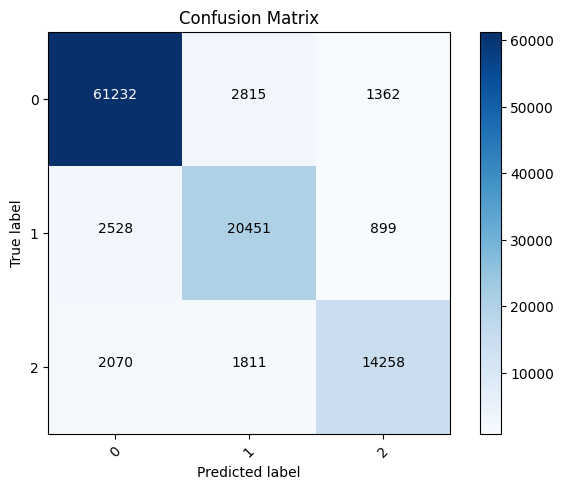

In [33]:
y_pred = ConvNeXt_model_predictions1.argmax(axis=1)
y_test=test_batches.classes

cm = confusion_matrix(y_test, y_pred)

cm_plot_labels = [0, 1, 2]
plot_confusion_matrix(cm, cm_plot_labels, title = 'Confusion Matrix')

In [34]:
accuracy_score(y_test, y_pred)

0.8930891962839536

: 

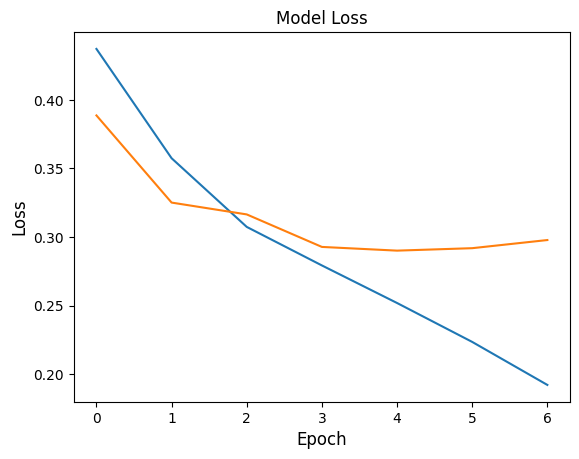

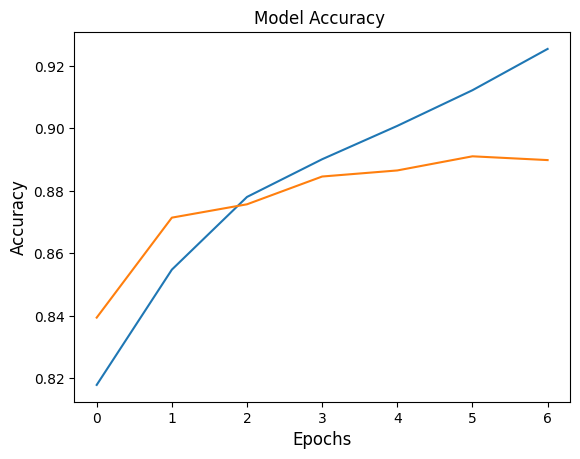

In [37]:
###### Model Plots

plt.plot(ConvNeXt_model_history.history['loss'])
plt.plot(ConvNeXt_model_history.history['val_loss'])
plt.title('Model Loss',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.xlabel('Epoch',fontsize=12)
plt.show()

plt.plot(ConvNeXt_model_history.history['accuracy'])
plt.plot(ConvNeXt_model_history.history['val_accuracy'])
plt.title('Model Accuracy ',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)

plt.xlabel('Epochs',fontsize=12)
plt.show()

In [26]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_test, y_pred, target_names=target_names,digits = 5))

NameError: name 'y_test' is not defined

In [15]:
ConvNeXt_modelRound2.compile(Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
ConvNeXt_modelRound2_history = ConvNeXt_modelRound2.fit(train_batches, validation_data = valid_batches ,callbacks=[es,mc2],epochs =4,shuffle = True)

Epoch 1/4


2023-05-02 23:57:54.276150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-05-02 23:57:55.126850: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-05-02 23:57:55.127727: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-05-02 23:57:55.127739: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2023-05-02 23:57:55.127772: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 

 1003/15667 [>.............................] - ETA: 2:14:46 - loss: 0.1306 - accuracy: 0.9503

2023-05-03 00:07:31.704117: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-05-03 00:07:31.851484: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-05-03 00:07:32.052813: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address

 1004/15667 [>.............................] - ETA: 2:15:35 - loss: 0.1305 - accuracy: 0.9503

2023-05-03 00:07:35.441850: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


15667/15667 [==============================] - ETA: 0s - loss: 0.1412 - accuracy: 0.9459

2023-05-03 02:57:51.563939: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-05-03 02:57:52.033903: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-05-03 02:57:52.230620: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address

15667/15667 [==============================] - 10837s 689ms/step - loss: 0.1412 - accuracy: 0.9459 - val_loss: 0.3282 - val_accuracy: 0.8910
Epoch 2/4
15667/15667 [==============================] - 9759s 623ms/step - loss: 0.1056 - accuracy: 0.9597 - val_loss: 0.3599 - val_accuracy: 0.8886
Epoch 3/4
15667/15667 [==============================] - 9232s 589ms/step - loss: 0.0794 - accuracy: 0.9701 - val_loss: 0.3831 - val_accuracy: 0.8882
Epoch 3: early stopping


In [16]:
ConvNeXt_modelRound2.compile(Adam(learning_rate = 0.00001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
ConvNeXt_modelRound4_history = ConvNeXt_modelRound2.fit(train_batches, validation_data = valid_batches, epochs = 6 ,shuffle = True)

Epoch 1/6
15667/15667 [==============================] - 9320s 592ms/step - loss: 0.0230 - accuracy: 0.9919 - val_loss: 0.5505 - val_accuracy: 0.8951
Epoch 2/6
15667/15667 [==============================] - 9267s 591ms/step - loss: 0.0096 - accuracy: 0.9969 - val_loss: 0.6691 - val_accuracy: 0.8959
Epoch 3/6
15667/15667 [==============================] - 9292s 593ms/step - loss: 0.0053 - accuracy: 0.9985 - val_loss: 0.7438 - val_accuracy: 0.8960
Epoch 4/6
15667/15667 [==============================] - 9278s 592ms/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 0.7942 - val_accuracy: 0.8957
Epoch 5/6
15667/15667 [==============================] - 9272s 592ms/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.9580 - val_accuracy: 0.8961
Epoch 6/6
15667/15667 [==============================] - 9299s 594ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 1.0840 - val_accuracy: 0.8958


In [17]:
ConvNeXt_modelRound2.compile(Adam(learning_rate = 0.000005), loss = 'categorical_crossentropy', metrics = ['accuracy'])
ConvNeXt_modelRound5_history = ConvNeXt_modelRound2.fit(train_batches, validation_data = valid_batches, epochs = 2 ,shuffle = True)

Epoch 1/2
15667/15667 [==============================] - 9903s 630ms/step - loss: 7.6357e-04 - accuracy: 0.9998 - val_loss: 1.2486 - val_accuracy: 0.8956
Epoch 2/2
15667/15667 [==============================] - 9273s 592ms/step - loss: 4.3039e-04 - accuracy: 0.9999 - val_loss: 1.4041 - val_accuracy: 0.8964


In [ ]:
# ConvNeXt_model.save('eegconvnext1.h5')
ConvNeXt_modelRound2.save('/home/hira_masood/Desktop/EEG/trained_model/convNextBase2')